# Introduction

We will build from scratch a class of convolutional neural networks (CNNs) for 2D, implementing the algorithms using only minimal libraries such as NumPy.


We will also create a pooling layer and so on to complete the basic form of the CNN. The name of the class should be Scratch2dCNNClassifier.

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def println(*str):
    for i in str:
        print(i)

# Test Forward Propagation (problem 2)

## NOTE
- [Reference](http://d2l.ai/chapter_convolutional-neural-networks/channels.html)
- Multiple output just means repeating different kernels many times, each gives one output.
- The kernel shape should be ($n_{out},n_{in},k_{height},k_{width}$)
- Summing all the input channels give one output result

In [168]:
# creating data, weight and bias
np.random.seed(0)
n_in = 1
n_out = 2
dim = (4,4)
kernel_size = (3,3)
print('n_in', n_in)
print('n_out', n_out)
print('dim',dim)
print('kernel_size', kernel_size)

# X = np.random.randint(0,10,(n_in, *dim))
X = np.array([[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]])
println('X',X.shape,  X)

dup_needed = True
# W = np.random.randint(0,2,(n_out, n_in, *kernel_size)) #init kernel
W = np.array([[[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]]],
              [[[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]]])
B = np.random.randint(0,1, n_out)
println('W', W.shape, W)
println('B', B)

n_in 1
n_out 2
dim (4, 4)
kernel_size (3, 3)
X
(1, 4, 4)
[[[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]
  [13 14 15 16]]]
W
(2, 1, 3, 3)
[[[[ 0.  0.  0.]
   [ 0.  1.  0.]
   [ 0. -1.  0.]]]


 [[[ 0.  0.  0.]
   [ 0. -1.  1.]
   [ 0.  0.  0.]]]]
B
[0 0]


In [169]:
# duplicate X to match n_out
if dup_needed:
    X = np.vstack([[X]] * n_out)
    println('X', X.shape, X)

X
(2, 1, 4, 4)
[[[[ 1  2  3  4]
   [ 5  6  7  8]
   [ 9 10 11 12]
   [13 14 15 16]]]


 [[[ 1  2  3  4]
   [ 5  6  7  8]
   [ 9 10 11 12]
   [13 14 15 16]]]]


In [170]:
# forward

in_x, in_y = dim
ker_x, ker_y = kernel_size
conv_size_x = in_x - ker_x + 1
conv_size_y = in_y - ker_y + 1
output_shape = (conv_size_x, conv_size_y)
result = np.ones((n_out, *output_shape))
print('expected output shape: ', output_shape)
print('result shape: ', result.shape)
print('Xshape: ', X.shape)
for i in range(conv_size_x):
    for j in range(conv_size_y):
        print('convolving at: ', i,j)
        temp_x = X[:,:, i : i + ker_x, j : j + ker_y]
        # println('before: ', temp_x, temp_x.shape)
        temp = temp_x * W
        # print(1,temp)
        temp = np.sum(temp, axis = (2,3))
        # print(2, temp)
        temp = np.sum(temp, axis = 1) 
        # print(3,temp)
        result[:,i,j] = temp + B
        print(4,result[:,i,j] )

println('Forward', result.shape, result)

expected output shape:  (2, 2)
result shape:  (2, 2, 2)
Xshape:  (2, 1, 4, 4)
convolving at:  0 0
4 [-4.  1.]
convolving at:  0 1
4 [-4.  1.]
convolving at:  1 0
4 [-4.  1.]
convolving at:  1 1
4 [-4.  1.]
Forward
(2, 2, 2)
[[[-4. -4.]
  [-4. -4.]]

 [[ 1.  1.]
  [ 1.  1.]]]


# Test backward prop (problem 2)

## NOTEs
- Basic backward prop [Ref](https://www.youtube.com/watch?v=i94OvYb6noo)
- Using this property of chain rule, plus some clever tricks, we can find a great way to back propagate on conv neural network

### In ultra simplification form
The formula for forward propagation is basically (super simpilifield):

Given z is one cell of the output propagation, x are the selected cells from input X for one convolution, W is kernel and b is bias, the forward prop formula is as follows (for one output cell):
$$ z = y + b $$
$$ y = \sum_ix_i*w_i $$

So in backward propagation, given $\frac{dL}{dZ}$, with dz is one cell of dZ
$$\frac{dz}{dy} = \frac{dz}{db} = 1 \Rightarrow \frac{dL}{db} = \frac{dL}{dz}\frac{dz}{db} = \frac{dL}{dz}$$

Continuing, let's simply denote any sum $\sum$  as all the values that has the contribution of (or related to) a cell xi, So:
$$\frac{dL}{dx_i} = \sum \frac{dL}{dz}\frac{dz}{dy}\frac{dy}{dx_i}$$
$$ = \sum (\frac{dL}{dz} *1* w_i) $$ 
with wi being the weight that was use to multiply with xi to get corresponding y

To put this in words, the gradient of some $x_i$ is gradient of each of the output cell that $x_i$ contributed to multiply with the corresponding weight of $x_i$ used in that output cell.

So our formula is just basically some correct W multiply with some correct dZ. Just need to select the correct ones for each x. Here's an example of the gradient dX for (3,3) input with (2,2) kernel

- **X:**
$$\begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{bmatrix}$$

- **dL/dx**, given the formula i described above, y here is actually dy or dz (i write y for simplicity)

$$\begin{bmatrix}
y1w1 & y1w2 + y2w3 & y3w3 \\ 
y1w3 + y3w1 & y1w4 + y2w3 + y3w2 + y4w1 & y2w4 + y4w2 \\ 
y3w3 & y3w4 + y4w3 & y4w4 
\end{bmatrix}$$

The way to get this output is to use a clever trick: **convolution + padding + transformed kernel**
- We rotate the kernel by 180 degrees
- And convove it through the padded gradient dZ (or dY)
- In the previoud example, padding is one, after convole gives expected result

The result blew my mind

### So how about gradient of weight?

Remember the function?

$$ y = \sum_ix_i*w_i $$

Given that, the formula is basically the same, just with different selection of x and z and different output shape

We, similar to the above tric, will
- Use the gradient of output Z as a kernel
- Convolve it through the input X
- Result is gradient of kernel W ( or K what ever you call it )

In [171]:
# sample dZ
dZ = np.array([[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]])
print('Grad dZ shape: ', dZ.shape)

Grad dZ shape:  (2, 2, 2)


In [172]:
# let's quickly define a convolve method, copying from the forward method
def convolve(X,K, B = None): #NOTE: INPUT FOR THIS METHOD MUST HAVE 4 dimensions (out, in, height, width)
    in_x, in_y = X.shape[-2], X.shape[-1]
    c_out, c_in, ker_x, ker_y = K.shape
    B = B if not B is None else np.zeros(c_out)
    x_out = in_x - ker_x + 1
    y_out = in_y - ker_y + 1
    output_shape = (x_out, y_out)
    result = np.ones((c_out, *output_shape))
    # print('result shape: ', result.shape)
    # print('in,out: ', c_in, c_out)
    # print('kshape: ', K.shape, 'Xshape: ', X.shape)
    for i in range(x_out):
        for j in range(y_out):
            temp_x = X[:,:, i : i + ker_x, j : j + ker_y]
            temp = temp_x * K
            temp = np.sum(temp, axis = (2,3))
            temp = np.sum(temp, axis = 1) 
            result[:,i,j] = temp + B

    # println('Final convolve result: ', result, result.shape)
    return result

def flip180(arr, axes = (-2,-1)):
    new_arr = np.rot90(arr,2, axes = axes)
    return new_arr
def padded(arr, pad_size = 1):
    return np.pad(arr, ((0,0),(0,0),(pad_size, pad_size),(pad_size, pad_size)), 'constant')
def swap_in_out_channels(arr, ax1 = 0, ax2 = 1):
    return np.swapaxes(arr, ax1, ax2)

In [173]:
# back prop

# remember to flip in/out channel of weights
W = swap_in_out_channels(W)

# bias gradient
dZ_dB = dZ
print('dZ_dB: ', dZ_dB, dZ_dB.shape)

#z with added dimension
dZ = np.stack([dZ]*n_in, axis = 0)
# println('Dz: ', dZ, dZ.shape)
# x gradient
padded_dZ = padded(dZ, pad_size = 2)
dZ_dX = convolve(padded_dZ, flip180(W))
println('Dz_dX: ', dZ_dX, dZ_dX.shape)
# w gradient
dZ_dW = convolve(swap_in_out_channels(X), dZ)
println('dZ_dW:', dZ_dW, dZ_dW.shape)

dZ_dB:  [[[ -4  -4]
  [ 10  11]]

 [[  1  -7]
  [  1 -11]]] (2, 2, 2)
Dz_dX: 
[[[  0.   0.   0.   0.]
  [  0.  -5.   4.  -7.]
  [  0.  13.  27. -11.]
  [  0. -10. -11.   0.]]]
(1, 4, 4)
dZ_dW:
[[[30. 27. 24.]
  [18. 15. 12.]
  [ 6.  3.  0.]]]
(1, 3, 3)


# Suppporting Classes

In [174]:
from numpy.random import default_rng
rng = default_rng()

class SimpleInitializer:
    def __init__(self, sigma = 0.1):
        self.sigma = sigma
    
    def W(self, dimension = ()):
        return rng.normal(0, self.sigma, dimension)
    
    def B(self,n=0):
        return rng.normal(0, self.sigma, n)


# Test
# simp_init = SimpleInitializer()
# w = simp_init.W(dimension = (3,2))
# b = simp_init.B(2)

# println('W', w)
# println('B', b)

# x = np.random.randint(5,size = (2,3))
# println('X', x)

# println('x*w + b', x@w + b)

In [175]:
class SGD():
    def __init__(self, learning_rate = 0.01):
        self.learning_rate = learning_rate
    def update(self, layer, dW, dB):
        layer.W = layer.W - self.learning_rate * dW
        layer.B = layer.B - self.learning_rate * dB


# Problem 1
2D Convolutional Layer

# CONV2D

In [176]:
class Conv2D:
    def __init__(self, 
        initializer = SimpleInitializer(), 
        optimizer = SGD(), 
        kernel_size = (3,3), 
        n_out_channels = 3, 
        padding = 0, 
        stride = 1):
        #! let's not consider padding and stride at the moment
        
        self.initializer = initializer
        self.optimizer = optimizer
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.n_out = n_out_channels
        self.skip_init_weight = False

    def forward(self,X):
        result = []
        for sample in X:
            result.append(self._forward(sample))
        return np.stack(result,0)

    def backward(self,dZ):
        result = []
        for sample in dZ:
            result.append(self._backward(sample))
        return np.stack(result,0)

    def _forward(self, X):
        if X.ndim != 3:
            raise 'Input must be 3-dimensional (input_channels, height, width)'
        
        # init size
        self.n_in, self.n_row, self.n_col = X.shape

        # init weight and biases
        if not self.skip_init_weight:
            self.W = self.initializer.W(dimension = (self.n_out, self.n_in, *self.kernel_size))
            self.B = self.initializer.B(self.n_out)
            self.skip_init_weight = True

        # add one duplicated dimension to X
        self.X = np.stack([X]*self.n_out)

        return self.convolve(self.X, self.W, self.B)

    def _backward(self, dZ):
        if dZ.ndim != 3:
            raise 'Input Gradient must be 3-dimensional (output_channels, height, width)'

        # remember to flip in/out channel of weights and X
        W = self.swap_in_out_channels(self.W)
        X = self.swap_in_out_channels(self.X)
        # bias gradient
        dZ_dB = dZ.sum(axis = (1,2))
        #z with added dimension
        dZ = np.stack([dZ]*self.n_in, axis = 0)
        # w gradient
        dZ_dW = self.convolve(X, dZ)

        self.optimizer.update(self, dZ_dW, dZ_dB)

        
        #z with pad
        pad_x, pad_y = self.dz_padsize()
        padded_dZ = self.padded(dZ, pad_x, pad_y)
        # x gradient
        dZ_dX = self.convolve(padded_dZ, self.flip180(W))
        return dZ_dX


    def convolve(self, X, W, B = None):
    #NOTE: INPUT FOR THIS METHOD MUST HAVE 4 dimensions (out, in, height, width)
        in_x, in_y = X.shape[-2], X.shape[-1]
        c_out, c_in, ker_x, ker_y = W.shape
        B = B if not B is None else np.zeros(c_out)
        x_out = in_x - ker_x + 1
        y_out = in_y - ker_y + 1
        output_shape = (x_out, y_out)
        result = np.ones((c_out, *output_shape))
        for i in range(x_out):
            for j in range(y_out):
                temp_x = X[:,:, i : i + ker_x, j : j + ker_y]
                temp = temp_x * W
                temp = np.sum(temp, axis = (2,3))
                temp = np.sum(temp, axis = 1) 
                result[:,i,j] = temp + B
        return result
    
    #! HELPERS

    def flip180(self, arr, axes = (-2,-1)):
        new_arr = np.rot90(arr,2, axes = axes)
        return new_arr
    def padded(self, arr, pad_x = 1, pad_y = 1):
        return np.pad(arr, ((0,0),(0,0),(pad_x, pad_x),(pad_y, pad_y)), 'constant')
    def swap_in_out_channels(self, arr, ax1 = 0, ax2 = 1):
        return np.swapaxes(arr, ax1, ax2)
    def dz_padsize(self):
        return self.kernel_size[0] - 1, self.kernel_size[1] - 1

In [177]:
# Test conv2D

cnn = Conv2D(kernel_size = (3,3), n_out_channels = 2)
cnn.skip_init_weight = True
cnn.W = W
cnn.B = B

X = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
cnn.W = np.array([[[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]]],
              [[[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]]])
cnn.B = np.array([0,0])
forward = cnn.forward(X)
print(cnn.n_out, cnn.n_in)

# sample dZ
dZ = np.array([[[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]]])
backward = cnn.backward(dZ)

println('Forward (Z): ', forward.shape, forward)
println('Backward: (dZ/dX) ', backward.shape, backward)

2 1
Forward (Z): 
(1, 2, 2, 2)
[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]
Backward: (dZ/dX) 
(1, 1, 4, 4)
[[[[  0.   0.   0.   0.]
   [  0.  -5.   4.  -7.]
   [  0.  13.  27. -11.]
   [  0. -10. -11.   0.]]]]


# Problem 3
Output size after 2-dimensional convolution

In [178]:
def conv_dim(dim, ker, pad, stride):
    dim, ker, pad, stride = np.array(dim), np.array(ker), np.array(pad), np.array(stride)
    result = (dim + 2 * pad - ker)/stride + 1
    return result.astype(np.int64)

dim = (4,4)
ker = (2,2)
pad = (2,2)
stride = (2,2)
print('Conv dim: ', conv_dim(dim, ker, pad, stride)) 


Conv dim:  [4 4]


# Problem 4
Creation of max pooling layer

In [179]:
from numpy import unravel_index
class MaxPool2D():
    def __init__(self, pool_size = (2,2), padding = (0,0), stride = (1,1)):
        self.pool_size = pool_size
        self.padding = padding
        self.stride = stride

    def forward(self,X):
        result = []
        for sample in X:
            result.append(self._forward(sample))
        return np.stack(result,0)

    def backward(self,dZ):
        result = []
        for sample in dZ:
            result.append(self._backward(sample))
        return np.stack(result,0)

    def _forward(self, X):
        if X.ndim != 3: raise 'Invalid dimension, must be 3 (in, height, width)'

        self.dim = X.shape[1:]
        self.out_x, self.out_y = conv_dim(self.dim, self.pool_size, self.padding, self.stride)

        output = []
        self.max_indexes_array = []
        for X_channel in X:
            pool_result, max_indexes = self.pool_channel(X_channel)
            output.append(pool_result)
            self.max_indexes_array.append(max_indexes)
        return np.stack(output, 0)
    
    def pool_channel(self, X):
        output = np.zeros((self.out_x, self.out_y))
        x_pool, y_pool = self.pool_size
        max_indexes = []
        for i in range(self.out_x):
            for j in range(self.out_y):
                temp_x = X[i : i + x_pool,j : j + y_pool]

                kernel_max_index = unravel_index(temp_x.argmax(), temp_x.shape)
                max_index = (kernel_max_index[0] + i, kernel_max_index[1] + j)
                output[i,j] = X[max_index]
                max_indexes.append(max_index)
        return output, max_indexes

    def _backward(self, dZ): 
        dX = []
        for channel, dz in enumerate(dZ):
            dx = np.zeros(self.dim)
            for i, gradient in enumerate(dz.flatten()):
                max_idx = self.max_indexes_array[channel][i]
                
                dx[max_idx] = gradient
            dX.append(dx)
        return np.stack(dX, 0) 




In [180]:
# test max pool
X = np.arange(27)
X = X.reshape((1,3,3,3))
println('X', X)
pool_layer = MaxPool2D()
forward = pool_layer.forward(X)
println('Pool forward: ', forward.shape, forward)

dZ = np.arange(12)
dZ = dZ.reshape((1,3,2,2))
println('dZ', dZ)
backward = pool_layer.backward(dZ)
println('Pool backward: ', backward.shape, backward)

X
[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]]

  [[ 9 10 11]
   [12 13 14]
   [15 16 17]]

  [[18 19 20]
   [21 22 23]
   [24 25 26]]]]
Pool forward: 
(1, 3, 2, 2)
[[[[ 4.  5.]
   [ 7.  8.]]

  [[13. 14.]
   [16. 17.]]

  [[22. 23.]
   [25. 26.]]]]
dZ
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]

  [[ 8  9]
   [10 11]]]]
Pool backward: 
(1, 3, 3, 3)
[[[[ 0.  0.  0.]
   [ 0.  0.  1.]
   [ 0.  2.  3.]]

  [[ 0.  0.  0.]
   [ 0.  4.  5.]
   [ 0.  6.  7.]]

  [[ 0.  0.  0.]
   [ 0.  8.  9.]
   [ 0. 10. 11.]]]]


# Problem 5 
Average Pooling layer

In [181]:
class AveragePool2D():
    def __init__(self, pool_size = (2,2), padding = (0,0), stride = (1,1)):
        self.pool_size = pool_size
        self.padding = padding
        self.stride = stride

    def _forward(self, X):
        if X.ndim != 3: raise 'Invalid dimension, must be 3 (in, height, width)'

        self.dim = X.shape[1:]
        out_dim = conv_dim(self.dim, self.pool_size, self.padding, self.stride)
        
        return self.pool_full(X, out_dim)
        
    def forward(self,X):
        result = []
        for sample in X:
            result.append(self._forward(sample))
        return np.stack(result,0)

    def backward(self,dZ):
        result = []
        for sample in dZ:
            result.append(self._backward(sample))
        return np.stack(result,0)

    def pool_full(self, X, out_dim):
        output = []
        for X_channel in X:
            pool_result = self.pool_channel(X_channel, out_dim)
            output.append(pool_result)
        return np.stack(output, 0)
    
    def pool_channel(self, X, out_dim):
        out_x, out_y = out_dim
        output = np.zeros((out_x, out_y))
        x_pool, y_pool = self.pool_size
        for i in range(out_x):
            for j in range(out_y):
                temp_x = X[i : i + x_pool, j : j + y_pool]
                output[i,j] = temp_x.mean()
        return output

    def _backward(self, dZ): 
        pad_x, pad_y = np.array(self.pool_size) - 1
        dZ = self.padded(dZ, pad_x, pad_y)

        return self.pool_full(dZ, self.dim)
    
    def padded(self, arr, pad_x = 1, pad_y = 1):
        return np.pad(arr, ((0,0),(pad_x, pad_x),(pad_y, pad_y)), 'constant')




In [182]:
# test mean pool
X = np.arange(27)
X = X.reshape((1,3,3,3))
println('X', X)
pool_layer = AveragePool2D()
forward = pool_layer.forward(X)
# println('Pool forward: ', forward.shape, forward)

dZ = np.arange(12)
dZ = dZ.reshape((1,3,2,2))
println('dZ', dZ)
backward = pool_layer.backward(dZ)
println('Pool backward: ', backward.shape, backward)

X
[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]]

  [[ 9 10 11]
   [12 13 14]
   [15 16 17]]

  [[18 19 20]
   [21 22 23]
   [24 25 26]]]]
dZ
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]

  [[ 8  9]
   [10 11]]]]
Pool backward: 
(1, 3, 3, 3)
[[[[0.   0.25 0.25]
   [0.5  1.5  1.  ]
   [0.5  1.25 0.75]]

  [[1.   2.25 1.25]
   [2.5  5.5  3.  ]
   [1.5  3.25 1.75]]

  [[2.   4.25 2.25]
   [4.5  9.5  5.  ]
   [2.5  5.25 2.75]]]]


# Problem 6
Smoothing

In [183]:
class FlattenLayer():
  def __init__(self): pass
  def forward(self, X):
    self.input_shape = X.shape
    return X.reshape(X.shape[0],-1) #flatten the input dimension, keep the channels

  def backward(self,dZ):
    return dZ.reshape(self.input_shape)

# test mean pool
X = np.arange(27)
X = X.reshape((3,1,3,3))
# println('X', X)
flatten_layer = FlattenLayer()
forward = flatten_layer.forward(X)
println('Pool forward: ', forward.shape, forward)
# println('Pool forward: ', forward.shape, forward)

dZ = X
# println('dZ', dZ)
backward = flatten_layer.backward(dZ)
println('Pool backward: ', backward.shape, backward)

Pool forward: 
(3, 9)
[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]]
Pool backward: 
(3, 1, 3, 3)
[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]]]


 [[[ 9 10 11]
   [12 13 14]
   [15 16 17]]]


 [[[18 19 20]
   [21 22 23]
   [24 25 26]]]]


# Problem 7
Leaning and Estimation

# Redefining other needed classes

## Activations

In [184]:
#! activations..............

class ActivationFunction():
  def forward(self,A):
    pass
  def backward(self,dZ):
    pass
class Tanh(ActivationFunction):
  def forward(self,A):
    self.A = A
    Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
    return Z
  def backward(self,dZ):
    A = self.A
    dA = dZ * (1 - np.tanh(A) ** 2)
    return dA
  
class SoftMax(ActivationFunction):
  def forward(self,A):
    self.A = A
    Z = np.exp(A) / np.sum(np.exp(A), axis = 1).reshape(-1,1)
    return Z
  def backward(self,Z,Y):
    A = self.A
    nb = Z.shape[0]
    dA = 1/nb * (Z - Y)
    return dA
class ReLU(ActivationFunction):
  def forward(self,A):
    self.A = A
    relu = A * np.where(A > 0, 1,0)
    return relu
  def backward(self,dZ):
    df = np.where(self.A > 0, 1,0)
    dA = dZ * df
    return dA

## Main Layers

In [185]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer = SimpleInitializer(), optimizer = SGD()):
        # Initialize
        self.optimizer = optimizer
        self.n_nodes1, self.n_nodes2 = n_nodes1, n_nodes2
        # Initialize self.W and self.B using the initializer method
        self.W = initializer.W((n_nodes1, n_nodes2))
        self.B = initializer.B(n_nodes2)
        pass
    def forward(self, X):   
        self.X = X
        A = X @ self.W + self.B
        return A
    def backward(self, dA):
        # update
        self.dA = dA
        dW = self.calc_dW()
        dB = self.calc_dB()
        self.dZ = self.calc_dZ()

        self.optimizer.update(self, dW, dB)
        return self.dZ
        # return self.dZ
    def calc_dB(self):
        dB = self.dA.sum(axis = 0).reshape(1,-1)  
        return dB
    def calc_dW(self):
        dW = self.X.T @ self.dA
        return dW
    def calc_dZ(self):
        dZ = self.dA @ self.W.T
        return dZ

class Conv1DBatch:
  def __init__(self, filter_size = 3, n_input = 2, n_output = 3, optimizer = SGD(), initializer = SimpleInitializer(), padding = 0):
    # Initialize
    self.optimizer = optimizer
    self.filter_size = filter_size
    # Initialize self.W and self.B using the initializer method
    self.filter_size = filter_size
    self.n_input = n_input
    self.n_output = n_output

    if initializer == None:
      self.W = np.ones((n_output, n_input,filter_size))
      self.B = np.ones(n_output)
    else:
      self.W = initializer.W((n_output, n_input, filter_size))
      self.B = initializer.B(n_output)
    #padding and stride
    self.padding = padding
        
  def forward(self,X): #! NOTE: X must be 3 dimensional (batch_size, channel_count, feature_count)
    self.batch_size = len(X)
    X = np.pad(X,[(0,0),(0,0),(self.padding, self.padding)], mode = 'constant')
    self.X = X
    result = []
    for x in self.X:
      result.append(self._forward_sample(x))
    # print('forward: ', np.array(result).shape)
    return np.array(result)
  def _forward_sample(self,X):    
    output = []
    for i in range(self.n_output):
      filt = self.W[i]
      bias = self.B[i]
      conv = self.convolve(filt, X)
      output.append(conv.sum(axis = 0) + bias)
    return np.array(output)

  def backward(self, dA):
    # update
    self.dA = dA
    self.dX = []

    for i in range(self.batch_size):
      dW = self.calc_dW(i)
      dB = self.calc_dB(i)
      self.dx = self.calc_dx(i)
      self.optimizer.update(self, dW, dB)
      self.dX.append(self.dx) #! keep updating while calculating error for prev layer
      # print('dx: ', i, self.dx.shape,self.dx)
    self.dX = np.array(self.dX)
    return self.dX
    

  def calc_dW(self,sample_index):
    dW = []
    dupped_dA = np.repeat(self.dA[sample_index][:,np.newaxis, : ], self.n_input, axis=1)
    for i in range(self.n_output): #convolve each output_channel through X
      conv = self.convolve(dupped_dA[i], self.X[sample_index])
      dW.append(conv) 
    return np.array(dW)
  def calc_dB(self,sample_index):
    return np.array(self.dA[sample_index].sum(axis = 1))

  def calc_dx(self, sample_index): #! careful
    pad_dA = self.pad_dA(sample_index) #match a with x
    flipped_W = np.flip(self.W,axis = 2).reshape(self.n_input,self.n_output, -1) # flip each filter and the in_out dim also
    output = []
    for i in range(self.n_input):
      filt = flipped_W[i]
      conv = self.convolve(filt, pad_dA)
      output.append(conv.sum(axis = 0))
    return np.array(output)
  def pad_dA(self,sample_index):
    array = self.dA[sample_index]
    n_features_in = array.shape[1]
    n_features_out = self.X.shape[-1]
    filter_size = self.filter_size
    padding = (n_features_out - 1 + filter_size - n_features_in) // 2
    return self.pad(array, padding)
  def pad(self,array,padding):
    return np.pad(array,[(0,0),(padding, padding)], mode = 'constant')
  def convolve(self,F,X):
    A = []
    filter_size = F.shape[-1]
    feature_count = X.shape[-1]
    n_out_features = (feature_count - filter_size) + 1
    for i in range(n_out_features):
      A.append((X[...,i : i + filter_size] * F).sum(axis=-1))
    return np.array(A).T

# layer = Conv1DBatch(padding = 2)
# X = np.array([[[1,2,3],[4,5,6]], [[2,3,4],[5,6,7]]])
# layer.B = np.array([1,2,3])
# fr = layer.forward(X)
# bk = layer.backward(fr)
# println(fr.shape, fr, bk.shape, bk)
# X = X.reshape(X.shape[0], -1)
# layer = FC(n_nodes1 = X.shape[1], n_nodes2 = 3)
# fr = layer.forward(X)
# bk = layer.backward(fr)
# println(fr.shape, fr, bk.shape, bk)

## Others

In [186]:
class AdaGrad():
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.Hw = 0
        self.Hb = 0
    def update(self, layer, dW, dB):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        #ada weight

        eps = 1e-6
        self.Hw += dW ** 2
        self.Hb += dB ** 2
        layer.W += - self.lr * (1 / np.sqrt(self.Hw + eps)) * dW
        layer.B += - self.lr * (1 / np.sqrt(self.Hb + eps)) * dB

class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y = None, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index] if y is not None else None
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        if self._y is not None:
          return self._X[p0:p1], self._y[p0:p1] 
        else:
          return self._X[p0:p1]       
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        if self._y is not None:
          return self._X[p0:p1], self._y[p0:p1] 
        else:
          return self._X[p0:p1]

class TransparentFunction():
    def forward(self,X):
        return X
    def backward(self,dA):
        return dA

## Neural network

In [187]:
from sklearn.metrics import accuracy_score

class DeepNeuralNetworkClassifier():
    def __init__(self,encoder, max_iter = 5, lr = 0.1, batch_size = 20 ,
               verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.sigma = 0.01
        self.batch_size = batch_size # batch size 
        
        #layers and activations
        self.layers = []
        self.activations = []

    def add(self,layer, activation):
      self.layers.append(layer)
      self.activations.append(activation)
        
    def enum_layer_act(self, rev = False):
      zipped = zip(self.layers, self.activations)
      if rev:
        return enumerate(reversed(list(zipped)))
      return enumerate(zipped)

    def forward_prop(self,X):
      Z = X
      for i, (layer, activation) in self.enum_layer_act():
        A = layer.forward(Z)
        Z = activation.forward(A)
        if self.debug:
          print(f'Z{i+1}: ', Z.shape, A.shape)
      return Z

    def backward_prop(self,Z,y):
      dA = self.activations[-1].backward(Z,y)
      if self.debug:
        print(f'Backward last Y: ', dA.shape)
      for i, (layer, activation) in self.enum_layer_act(rev = True):
        if i == 0: #last layer has different activation backward!
          dZ = layer.backward(dA)
          if self.debug:
            print(f'Backward layer: {len(self.layers) - (i)} ', dZ.shape)
          continue
        dA = activation.backward(dZ)
        dZ = layer.backward(dA)
        if self.debug:
          print(f'Backward layer: {len(self.layers) - (i)} ', dZ.shape)
        
    
    def cross_entropy_error(self,Z,y):
      return (np.log(Z) * y).sum() / (- len(Z))

    def predict(self,X):
      y = np.zeros(X.shape[0])
      Z  = self.forward_prop(X)
      return self.encoder.transform(np.argmax(Z, axis = 1).reshape(-1,1))


    def fit(self,X,y, X_val = None, y_val = None):
      #prepare
      self.n_features = X.shape[1]
      self.lenx = len(X)
      self.batch_count = len(GetMiniBatch(X,y,batch_size= self.batch_size)) #for debug

      if self.verbose:
          print('X shape: ', X.shape, 'type: ', X.dtype)
          print('Batch count: ', self.batch_count)
          # for i, (layer, activation) in self.enum_layer_act():
          #   print(f'Layer {i+1}: ', layer.n_nodes1, layer.n_nodes2)
          #   print(f'Activ: {i+1}:', activation.__class__.__name__)

      #train
      self.loss = np.zeros(self.epoch)
      self.accuracy = np.zeros(self.epoch)
      for i in range(self.epoch): #one full data ilteration
          if self.verbose: print('Epoch: ', i)
          self.get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
          for idx, (mini_X_train, mini_y_train) in enumerate(self.get_mini_batch):
              if self.debug: print('Current batch: ', idx, mini_X_train.shape, mini_y_train.shape)
              #train mini_batch
              Z = self.forward_prop(mini_X_train)
              self.backward_prop(Z,mini_y_train)


          #record loss data
          if self.debug: print('Predicting and recording loss/acc')
          Z = self.forward_prop(X)
          self.loss[i] = self.cross_entropy_error(Z,y)
          train_pred = self.predict(X)
          self.accuracy[i]  = accuracy_score(train_pred,y)
          if self.verbose:
              print(f'Loss {i}:', self.loss[i])
              print(f'Acc {i}:', self.accuracy[i])
              
      #verbose
      if self.verbose:
          print('Final train loss:',self.loss[-1])
          print('Final train accuracy:',self.accuracy[-1])


In [188]:
class UpdatedDNN():
    def __init__(self,encoder, max_iter = 5, lr = 0.1, batch_size = 20 ,
               verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.sigma = 0.01
        self.batch_size = batch_size # batch size 
        
        #layers (including activations)
        self.layers = []

    def add(self,layer):
      self.layers.append(layer)
        
    def enum_layers(self, rev = False):
      if rev:
        return enumerate(reversed(list(self.layers)))
      return enumerate(self.layers)

    def forward_prop(self,X):
      try:
        Z = X
        for i, layer in self.enum_layers():
          Z = layer.forward(Z)
          if self.debug:
            print(f'Z{i+1}: ', Z.shape)
      except BaseException as e:
        println('Error: ', e)
        print('ERROR LAYER INFORMATION:', layer.__class__.__name__, 'index: ', i + 1)
      return Z

    def backward_prop(self,Z,y):
      dZ = self.layers[-1].backward(Z,y)
      if self.debug:
        print(f'Backward last Y: ', dZ.shape)
      for i, layer in self.enum_layers(rev = True):
        if i == 0: continue #already calculated last backward
        dZ = layer.backward(dZ)
        if self.debug:
          print(f'Backward layer: {len(self.layers) - (i)} ', dZ.shape)
        
    
    def cross_entropy_error(self,Z,y):
      return (np.log(Z) * y).sum() / (- len(Z))

    def predict(self,X):
      y = np.zeros(X.shape[0])
      Z  = self.forward_prop(X)
      return self.encoder.transform(np.argmax(Z, axis = 1).reshape(-1,1))


    def fit(self,X,y, X_val = None, y_val = None):
      #prepare
      self.n_features = X.shape[1]
      self.lenx = len(X)
      self.batch_count = len(GetMiniBatch(X,y,batch_size= self.batch_size)) #for debug

      if self.verbose:
          print('X shape: ', X.shape, 'type: ', X.dtype)
          print('Batch count: ', self.batch_count)
          for i, layer in self.enum_layers():
            print(f'Layer {i+1}: ', layer.__class__.__name__)

      #train
      self.loss = np.zeros(self.epoch)
      self.accuracy = np.zeros(self.epoch)
      for i in range(self.epoch): #one full data ilteration
          if self.verbose: print('Epoch: ', i)
          self.get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
          for idx, (mini_X_train, mini_y_train) in enumerate(self.get_mini_batch):
              if self.debug: print('Current batch: ', idx, mini_X_train.shape, mini_y_train.shape)
              #train mini_batch
              Z = self.forward_prop(mini_X_train)
              self.backward_prop(Z,mini_y_train)


          #record loss data
          if self.debug: print('Predicting and recording loss/acc')
          Z = self.forward_prop(X)
          self.loss[i] = self.cross_entropy_error(Z,y)
          train_pred = self.predict(X)
          self.accuracy[i]  = accuracy_score(train_pred,y)
          if self.verbose:
              print(f'Loss {i}:', self.loss[i])
              print(f'Acc {i}:', self.accuracy[i])
              
      #verbose
      if self.verbose:
          print('Final train loss:',self.loss[-1])
          print('Final train accuracy:',self.accuracy[-1])


# Data Set

In [189]:
#data set
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#random subset since the data is too large
from sklearn.model_selection import train_test_split
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.075)

#reshape and add one channel to X
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

#scaling
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
#one hot encode for multiclass labels!
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

#validation split
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, train_size=0.8)
print([i.shape for i in [x_train, x_val, y_train, y_val]])

[(3600, 1, 28, 28), (900, 1, 28, 28), (3600, 10), (900, 10)]


In [190]:
# test run deep neural
model = UpdatedDNN(enc, debug = False, verbose = True, max_iter = 5)
n_in_features = x_train.shape[1]
batch_size  = 20
print('train shape: ', x_train.shape)
print('input features: ', n_in_features)
print('input channels: ', batch_size)


in_channel = x_train.shape[1]

# l1 = Conv1DBatch(filter_size = 3, n_input = in_channel, n_output = 1, optimizer = AdaGrad(0.1))
# model.add(l1)
# model.add(Tanh())
l1 = Conv2D(n_out_channels = 2, kernel_size = (8,8))
model.add(l1)
model.add(MaxPool2D(pool_size = (5,5)))
model.add(ReLU())

# l11 = MaxPool()
# model.add()
lshape = FlattenLayer()
model.add(lshape)
l2 = FC(578,100, SimpleInitializer(),SGD()) #cause output of conv is 394
model.add(l2)
model.add(Tanh())
l3 = FC(100,10, SimpleInitializer(),SGD())
model.add(l3)
model.add(SoftMax())


train shape:  (3600, 1, 28, 28)
input features:  1
input channels:  20


In [191]:
print('xshape: ', x_train.shape, 'yshape: ', y_train.shape)
model.fit(x_train, y_train)

xshape:  (3600, 1, 28, 28) yshape:  (3600, 10)
X shape:  (3600, 1, 28, 28) type:  float64
Batch count:  180
Layer 1:  Conv2D
Layer 2:  MaxPool2D
Layer 3:  ReLU
Layer 4:  FlattenLayer
Layer 5:  FC
Layer 6:  Tanh
Layer 7:  FC
Layer 8:  SoftMax
Epoch:  0
Loss 0: 1.492013494944866
Acc 0: 0.6308333333333334
Epoch:  1
Loss 1: 1.0687034757780534
Acc 1: 0.7497222222222222
Epoch:  2
Loss 2: 0.8398523367735573
Acc 2: 0.7947222222222222
Epoch:  3
Loss 3: 0.6944132532629612
Acc 3: 0.8172222222222222
Epoch:  4
Loss 4: 0.6200881833937789
Acc 4: 0.8305555555555556
Final train loss: 0.6200881833937789
Final train accuracy: 0.8305555555555556


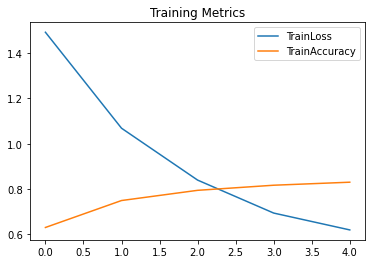

test acc:  0.8022222222222222


In [192]:

# loss result
plt.plot(model.loss, label = 'TrainLoss')
plt.plot(model.accuracy, label = 'TrainAccuracy')
plt.title('Training Metrics')
plt.legend()
plt.show()
# test result
pred = model.predict(x_val)
print('test acc: ', accuracy_score(pred, y_val))

# Problem 8
Lenet

**Subsampling is the modern equivalent of pooling. Let's make a modern version of it as follows. The activation function was also a sigmoid function back then, but we'll call it ReLU.**

1. Convolutional layer Number of output channels 6, filter size 5 x 5, stride 1
2. ReLU
3. Maximum pooling
4. Convolutional layer 16 output channels, filter size 5 x 5, stride 1
5. ReLU
6. Maximum pooling
7. Smoothing
8. All coupling layers 120 output nodes
9. ReLU
10. All coupling layers 84 output nodes
11. ReLU
12. All coupling layers Number of output nodes 10
13. Softmax Functions

In [193]:
lenet = UpdatedDNN(enc, debug = False, verbose = True, max_iter = 5)
layers = [
    Conv2D(n_out_channels=6, kernel_size = (5,5)),
    ReLU(),
    MaxPool2D(pool_size = (2,2)),
    Conv2D(n_out_channels=16, kernel_size = (5,5)),
    ReLU(),
    MaxPool2D(pool_size = (2,2)),
    FlattenLayer(),
    FC(5184, 120, SimpleInitializer(),SGD()),
    ReLU(),
    FC(120, 84, SimpleInitializer(),SGD()),
    ReLU(),
    FC(84, 10, SimpleInitializer(),SGD()),
    SoftMax()
]

[lenet.add(layer) for layer in layers];

In [194]:
print('xshape: ', x_train.shape, 'yshape: ', y_train.shape)
lenet.fit(x_train, y_train)

xshape:  (3600, 1, 28, 28) yshape:  (3600, 10)
X shape:  (3600, 1, 28, 28) type:  float64
Batch count:  180
Layer 1:  Conv2D
Layer 2:  ReLU
Layer 3:  MaxPool2D
Layer 4:  Conv2D
Layer 5:  ReLU
Layer 6:  MaxPool2D
Layer 7:  FlattenLayer
Layer 8:  FC
Layer 9:  ReLU
Layer 10:  FC
Layer 11:  ReLU
Layer 12:  FC
Layer 13:  SoftMax
Epoch:  0
Loss 0: 0.5597113988623933
Acc 0: 0.8305555555555556
Epoch:  1
Loss 1: 0.5022307156355194
Acc 1: 0.8586111111111111
Epoch:  2
Loss 2: 0.48734969861941724
Acc 2: 0.8708333333333333
Epoch:  3
Loss 3: 0.4879990131273452
Acc 3: 0.8725
Epoch:  4
Loss 4: 0.3717217675472228
Acc 4: 0.8988888888888888
Final train loss: 0.3717217675472228
Final train accuracy: 0.8988888888888888


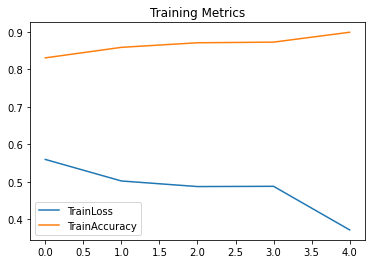

test acc:  0.8766666666666667


In [195]:
# loss result
plt.plot(lenet.loss, label = 'TrainLoss')
plt.plot(lenet.accuracy, label = 'TrainAccuracy')
plt.title('Training Metrics')
plt.legend()
plt.show()
# test result
pred = lenet.predict(x_val)
print('test acc: ', accuracy_score(pred, y_val))

# Problem 9
Survey of famous image recognition models

## AlexNet

- 2012 ImageNet LSVRC-2012 winner, large impact on computer vision ML
- ReLU activation after every convolutio or FC layer
- This was use on multiple gpus
- Pooling was overlapping not like previously non-overlapping methods.

## VGG

**Very Deep Convolutional Networks for Large-Scale Image Recognition**

- A family (VGG16, 19)
- 2014, very good even to this day, among top
- Model is a bunch of sequential filters, using 3x3 kenels to reduce the params and use ReLU activation
- Number of parameters is 138 bil, which makes it quite slower and larger model to train.
- Simple and intuitive in it's idea
- 1st Rank in the ImageNet ILSVRC-2014

# Problem 10
Calculation of output size and number of parameters

**Calculate the output size and the number of parameters for the following three convolution layers. For the number of parameters, please also consider the bias term.**

### In general

- Weight: n_out_channel * n_in_channel * ker_height * ker_width
- Bias: n_out_channel
- Output size: n_out_channel * out_height * out_width
- out_height, out_width with respect to kernel size, padding and stride

### Question 1

- Input size : 144 x 144, 3 channels
- Filter size: 3 x 3, 6 channels
- Stride : 1
- Padding: none

**Ans:**

- W: 6 x 3 x 3 x 3
- B: 6
- (out_height, out_width): (142, 142)
- output: 6 x 142 x 142

### Question 2

- Input size : 60x60, 24 channels
- Filter size: 3 x 3, 48 channels
- Stride : 1
- Padding: none

**Ans:**

- W: 48 x 24 x 3 x 3
- B: 48
- (out_height, out_width): (58, 58)
- output: 48 x 58 x 58

### Question 3

- Input size : 20x20, 10 channels
- Filter size: 3 x 3, 20 channels
- Stride: 2
- Padding: none

**Ans:**

- W: 20 x 10 x 3 x 3
- B: 20
- (out_height, out_width): (9, 9)
- output: 20 x 9 x 9


# Problem 11
Survey on filter size

- Smaller is prefered to capture the local connection among pixels and reveal repeating patterns
- Odd size filter is prefered since we want the result to be centered, given that most of convolution implementation takes the center as the place for the convolved result. 

### Size 1x1
- Mostly for channel reduction, squashing many channels into one

### Size 3x3
- The smallest odd size that works
- Computational in-expensive

[Very nice reference](https://icecreamlabs.com/2018/08/19/3x3-convolution-filters%E2%80%8A-%E2%80%8Aa-popular-choice/)